In [1]:
# Improve by ChatGPT & GitHub Copilot
# Running the requierements.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/requierements.ipynb

# Running functions_IT.ipynb
%run /bettik/PROJECTS/pr-data-ocean/riverama/Notebooks/OSSE_borrador/IT_modes/functions_IT_modes_v1.ipynb

In [2]:
ds = xr.open_mfdataset("/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Filtrage/ssh_it/ssh_it_*.nc",combine='nested',concat_dim='time_counter',parallel=True)

In [3]:
ssh_it = ds.sel(time_counter='2014-05-01T00:30:00') # Select one time step

In [4]:
# To cartesian grid
dx = 2 # in kilometers
ENSLAT2D, ENSLON2D, i_lat, i_lon = create_cartesian_grid(ssh_it.nav_lat[:,0].values,
                                                         ssh_it.nav_lon[0,:].values,
                                                         dx)
ENSLAT2D_flat = ENSLAT2D.flatten()
ENSLON2D_flat = ENSLON2D.flatten()

points = np.column_stack((ssh_it.nav_lat.data.flatten(), ssh_it.nav_lon.data.flatten()))
values = ssh_it.ssh_it.data.flatten()
target_grid = np.column_stack((ENSLAT2D_flat, ENSLON2D_flat))
ssh_it_cart = griddata(points, values, target_grid, method='linear')

ssh_it_cart= ssh_it_cart.reshape(ENSLAT2D.shape)

/home/riverama/.conda/envs/env-stage/lib/python3.11/site-packages/dask/array/core.py:1712: FutureWarning: The `numpy.column_stack` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [5]:
#INTERPOLATION OF NaNs # 
x_axis = Axis(np.arange(i_lon))
y_axis = Axis(np.arange(i_lat))
    
grid = Grid2D(y_axis, x_axis, ssh_it_cart.reshape((i_lat,i_lon)))
has_converged, filled = fill.gauss_seidel(grid)

mask_cart = np.isnan(ssh_it_cart.reshape((i_lat,i_lon)))

ssh_it_cart_filled = xr.DataArray(data=filled,
                           dims=["y","x"],
                           coords = dict(y=(["y"],np.arange(i_lat)), x=(["x"],np.arange(i_lon))
                         ))

In [6]:
k1 = 0.00252
k2 = 0.00964
k3 = 0.02100
k4 = 0.03100

nx = ssh_it_cart_filled['x'].size
ny = ssh_it_cart_filled['y'].size
dx = 2  #km

kx = np.fft.fftfreq(3*nx,dx) # km
ky = np.fft.fftfreq(3*ny,dx) # km
k, l = np.meshgrid(kx,ky)
wavenum2D = np.sqrt(k**2 + l**2)

wavenumbers_mode_1 = [0.5*k1,0.5*(k1+k2)] # in km
wavenumbers_mode_2 = [0.5*(k1+k2),0.5*(k2+k3)] # in km
wavenumbers_mode_3 = [0.5*(k2+k3),0.5*(k3+k4)] # in km

In [7]:
# Apply the bandpass filters
bandpass_mode_1 = bandpass(wavenumbers=wavenumbers_mode_1, nx=nx, ny=ny, wavenum2D=wavenum2D)
bandpass_mode_2 = bandpass(wavenumbers=wavenumbers_mode_2, nx=nx, ny=ny, wavenum2D=wavenum2D)
bandpass_mode_3 = bandpass(wavenumbers=wavenumbers_mode_3, nx=nx, ny=ny, wavenum2D=wavenum2D)

In [8]:
# Create the spatial window
window = create_spatial_window(nx=nx, ny=ny)

In [9]:
# Parallel processing to extract modes for single time step data
results = Parallel(n_jobs=-1, backend='multiprocessing')(delayed(extract_it_mode)(
    ssh_it_cart_filled.values, window, dx, bandpass_mode_1, bandpass_mode_2, bandpass_mode_3) for _ in range(1)
)

In [10]:
# Extract individual modes directly from the results
ssh_it_filtered_1, ssh_it_filtered_2, ssh_it_filtered_3 = results[0]

In [11]:
#lon2d, lat2d = np.meshgrid(ssh_hf.lon.values, ssh_hf.lat.values)
lon2d, lat2d = np.meshgrid(ssh_it.nav_lon[0,:].values, ssh_it.nav_lat[:,0].values)

In [12]:
# Interpolate filtered data back to original grid
def interpolate_back(filtered_data):
    return np.array([griddata(
        np.array([ENSLAT2D.flatten(), ENSLON2D.flatten()]).T,
        filtered_data.flatten(),
        (lat2d, lon2d),
        method='linear'
    )])

ssh_it_filtered_1_array = interpolate_back(ssh_it_filtered_1)
ssh_it_filtered_2_array = interpolate_back(ssh_it_filtered_2)
ssh_it_filtered_3_array = interpolate_back(ssh_it_filtered_3)

# Create DataArrays for each mode with nav_lat, nav_lon, and time_counter dimensions
time_counter = ssh_it.time_counter.values
ssh_it_mode_1 = xr.DataArray(
    data=ssh_it_filtered_1_array[0][:, :, None],  # Add a new axis for time_counter
    dims=['nav_lat', 'nav_lon', 'time_counter'],
    coords={'nav_lat': ssh_it.nav_lat[:, 0].values, 'nav_lon': ssh_it.nav_lon[0, :].values, 'time_counter': [time_counter]}
)

ssh_it_mode_2 = xr.DataArray(
    data=ssh_it_filtered_2_array[0][:, :, None],  # Add a new axis for time_counter
    dims=['nav_lat', 'nav_lon', 'time_counter'],
    coords={'nav_lat': ssh_it.nav_lat[:, 0].values, 'nav_lon': ssh_it.nav_lon[0, :].values, 'time_counter': [time_counter]}
)

ssh_it_mode_3 = xr.DataArray(
    data=ssh_it_filtered_3_array[0][:, :, None],  # Add a new axis for time_counter
    dims=['nav_lat', 'nav_lon', 'time_counter'],
    coords={'nav_lat': ssh_it.nav_lat[:, 0].values, 'nav_lon': ssh_it.nav_lon[0, :].values, 'time_counter': [time_counter]}
)

# Create a single xarray.Dataset
it_modes = xr.Dataset(
    {
        'ssh_it_mode_1': ssh_it_mode_1,
        'ssh_it_mode_2': ssh_it_mode_2,
        'ssh_it_mode_3': ssh_it_mode_3,
    }
)

# Display the dataset
it_modes

<xarray.Dataset> Size: 16MB
Dimensions:        (nav_lat: 853, nav_lon: 788, time_counter: 1)
Coordinates:
  * nav_lat        (nav_lat) float32 3kB -28.8 -28.79 -28.77 ... -15.72 -15.7
  * nav_lon        (nav_lon) float32 3kB 159.2 159.2 159.3 ... 172.3 172.3 172.3
  * time_counter   (time_counter) datetime64[ns] 8B 2014-05-01T00:30:00
Data variables:
    ssh_it_mode_1  (nav_lat, nav_lon, time_counter) float64 5MB 0.00397 ... 0...
    ssh_it_mode_2  (nav_lat, nav_lon, time_counter) float64 5MB -0.004588 ......
    ssh_it_mode_3  (nav_lat, nav_lon, time_counter) float64 5MB 0.0009439 ......

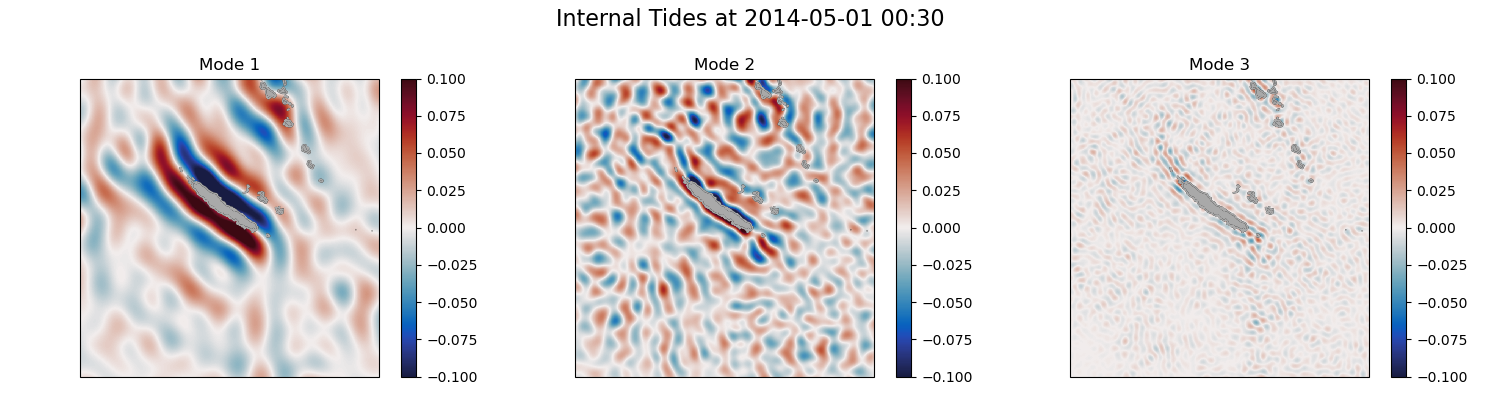

In [13]:
# Get the date for the title
date = it_modes.time_counter.values[0]
formatted_date = pd.to_datetime(date).strftime('%Y-%m-%d %H:%M')

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for each subplot
mode_titles = ['Mode 1', 'Mode 2', 'Mode 3']

# Custom land feature with blue inside and black borders
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            edgecolor='black', facecolor='darkgray')

for i, mode in enumerate(it_modes.data_vars):
    axs[i].set_extent([it_modes.nav_lon.min(), it_modes.nav_lon.max(), it_modes.nav_lat.min(), it_modes.nav_lat.max()], crs=ccrs.PlateCarree())
    im = axs[i].pcolormesh(it_modes['nav_lon'], it_modes['nav_lat'], it_modes[mode].isel(time_counter=0), cmap=cmocean.cm.balance, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree())
    axs[i].set_title(mode_titles[i])
    fig.colorbar(im, ax=axs[i], orientation='vertical')
    axs[i].add_feature(land_feature)  # Add the custom land feature
    axs[i].add_feature(cfeature.COASTLINE, edgecolor='darkgray')
    axs[i].set_aspect('equal')

# Set the main title
fig.suptitle(f'Internal Tides at {formatted_date}', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()

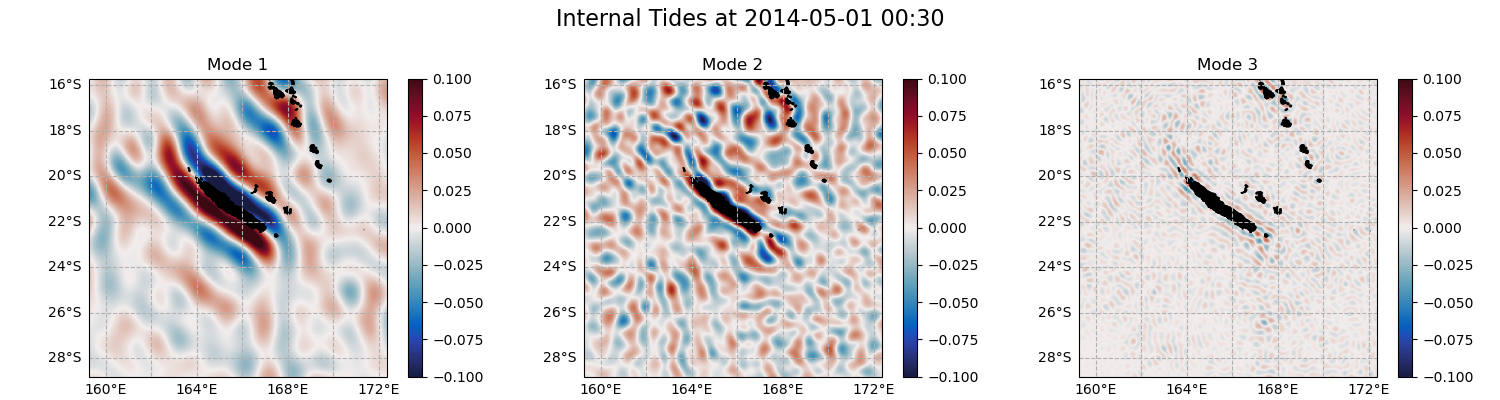

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean  # Assuming you have cmocean installed

# Get the date for the title
date = it_modes.time_counter.values[0]
formatted_date = pd.to_datetime(date).strftime('%Y-%m-%d %H:%M')

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw={'projection': ccrs.PlateCarree()})

# Titles for each subplot
mode_titles = ['Mode 1', 'Mode 2', 'Mode 3']

# Custom land feature with dark gray inside and black borders
land_feature = cfeature.NaturalEarthFeature('physical', 'land', '10m',
                                            edgecolor='black', facecolor='black')

for i, mode in enumerate(it_modes.data_vars):
    axs[i].set_extent([it_modes.nav_lon.min(), it_modes.nav_lon.max(), it_modes.nav_lat.min(), it_modes.nav_lat.max()], crs=ccrs.PlateCarree())
    im = axs[i].pcolormesh(it_modes['nav_lon'], it_modes['nav_lat'], it_modes[mode].isel(time_counter=0), cmap=cmocean.cm.balance, vmin=-0.1, vmax=0.1, transform=ccrs.PlateCarree())
    axs[i].set_title(mode_titles[i])
    fig.colorbar(im, ax=axs[i], orientation='vertical')
    axs[i].add_feature(land_feature)  # Add the custom land feature
    axs[i].add_feature(cfeature.COASTLINE, edgecolor='black')
    axs[i].set_aspect('equal')

    # Add gridlines and labels
    gl = axs[i].gridlines(draw_labels=True, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

# Set the main title
fig.suptitle(f'Internal Tides at {formatted_date}', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
plt.show()
